In [1]:
import sys
import os


# Go one level up to the 'main' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add this directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)


In [ ]:
# building the portfolio with the necessary packages
import datetime
import numpy as np
import pandas as pd

from portfolio import build_portfolio

start_date = datetime.datetime(2024, 4, 1)
end_date = "2025-03-30"

d = {
    0: {"Name": "MCD", "Allocation": 15},
    1: {"Name": "JNJ", "Allocation": 17},
    2: {"Name": "DIS", "Allocation": 18},
    3: {"Name": "AMZN", "Allocation": 10},
    4: {"Name": "GOOG", "Allocation": 12},
    5: {"Name": "MSFT", "Allocation": 20},
    # 6: {"Name": "AAPL", "Allocation": 15},
    # 7: {"Name": "JPM", "Allocation": 8},
    # 8: {"Name": "NVDA", "Allocation": 12},
    # 9: {"Name": "KO", "Allocation": 5},
    # 10: {"Name": "V", "Allocation": 7}
}


pf_allocation = pd.DataFrame.from_dict(d, orient="index")
names = pf_allocation["Name"].values.tolist()

pf = build_portfolio(
    names=names,
    pf_allocation=pf_allocation,
    start_date=start_date,
    end_date=end_date,
    data_api="yfinance",
    # market_index=market_index
)

R = pf.comp_mean_returns()
Sigma = pf.comp_cov()*252

sp_ratio = pf.comp_sharpe()

portfolio = pf.portfolio
# portfolio.to_latex()

# expected_return = 

d:\Guided quantum walk for portfolio optimization\main\portfolio.py:263: FutureWarning: YF.download() has changed argument auto_adjust default to True
  res: pd.DataFrame = yfinance.download(names, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed


'\\begin{tabular}{lll}\n\\toprule\n & Name & Allocation \\\\\n\\midrule\n0 & MCD & 15.000000 \\\\\n1 & JNJ & 17.000000 \\\\\n2 & DIS & 18.000000 \\\\\n3 & AMZN & 10.000000 \\\\\n4 & GOOG & 12.000000 \\\\\n5 & MSFT & 20.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

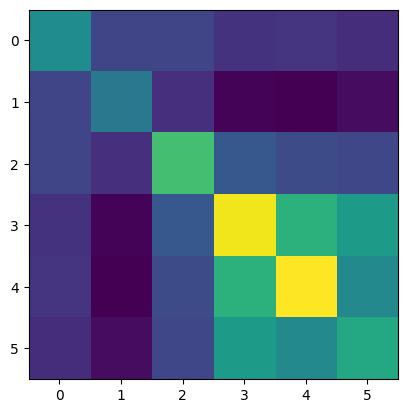

In [4]:
import matplotlib.pyplot as plt
plt.imshow(Sigma, interpolation='nearest')
plt.show()

In [4]:
# form the qubo problem

from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo

gamma = 0.5
B = len(d) // 2
portfolio = PortfolioOptimization(expected_returns=np.array(R), covariances=np.array(Sigma), risk_factor=gamma, budget=B)
qp = portfolio.to_quadratic_program()

qubo_conv = QuadraticProgramToQubo()
qubo_prob = qubo_conv.convert(qp)

cost_op = qubo_prob.to_ising()[0]

print(cost_op)

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ 0.05119031+0.j,  0.03830913+0.j, -0.11627964+0.j,  0.00634168+0.j,
 -0.02178483+0.j, -0.07385145+0.j,  1.01214571+0.j,  1.01218545+0.j,
  1.01070545+0.j,  1.01088297+0.j,  1.01033488+0.j,  1.01049312+0.j,
  1.00746266+0.j,  1.00720443+0.j,  1.00796534+0.j,  1.0137563 +0.j,
  1.01275618+0.j,  1.01224152+0.j,  1.0224437 +0.j,  1.02013985+0.j,
  1.01834201+0.j])


In [5]:
# classical solution using numpy minimum eigen solver

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver =  MinimumEigenOptimizer(exact_mes)

result1 = exact_eigensolver.solve(qubo_prob)
print(result1.prettyprint())

objective function value: -0.24616682174000104
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=0.0
status: SUCCESS


In [6]:
# This is quantum solution with the well known QAOA algorithm with the standard qiskit implementation

from qiskit_algorithms import QAOA
# from qiskit_aer.primitives import SamplerV2 as Sampler
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA 

cobyla = COBYLA()
cobyla.set_options(maxiter = 250)
# sampler = Sampler()
sampler = StatevectorSampler()
qaoa = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
optimizer = MinimumEigenOptimizer(qaoa)
result2 = optimizer.solve(qp) 

d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [7]:
print(result2.prettyprint())

objective function value: -0.24616682174000482
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=0.0
status: SUCCESS


In [11]:
# this is locally developed based on quantum walks and referenced qiskit's algorithm structure, quantum algorithm called `guided quantum walk`

from qiskit_aer.primitives import SamplerV2
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import NELDER_MEAD, COBYLA

from gqw_solver import GQW
nelde_mead = NELDER_MEAD(maxiter=25)
cobyla = COBYLA(maxiter=250)
# cobyla.set_options(maxiter = 25)

gqw = GQW(sampler = StatevectorSampler(), optimizer=nelde_mead, reps = 3, time = 1.3)

optimizer = MinimumEigenOptimizer(gqw)
result3 = optimizer.solve(qp)


new lambda vec [0.415 0.762 0.84  0.272 0.241 0.228]


d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


new lambda vec [0.43575 0.762   0.84    0.272   0.241   0.228  ]
new lambda vec [0.415  0.8001 0.84   0.272  0.241  0.228 ]
new lambda vec [0.415 0.762 0.882 0.272 0.241 0.228]
new lambda vec [0.415  0.762  0.84   0.2856 0.241  0.228 ]
new lambda vec [0.415   0.762   0.84    0.272   0.25305 0.228  ]
new lambda vec [0.415  0.762  0.84   0.272  0.241  0.2394]
new lambda vec [0.42191667 0.7747     0.854      0.27653333 0.22895    0.2318    ]
new lambda vec [0.425375 0.78105  0.861    0.2788   0.2169   0.2337  ]
new lambda vec [0.425375   0.73025    0.861      0.2788     0.23296667 0.2337    ]
new lambda vec [0.40116667 0.75776667 0.868      0.28106667 0.23028889 0.2356    ]
new lambda vec [0.41730556 0.75635556 0.82133333 0.28408889 0.22671852 0.23813333]
new lambda vec [0.41845833 0.75353333 0.791      0.29013333 0.21957778 0.2432    ]
new lambda vec [0.41807407 0.75447407 0.85711111 0.28811852 0.22195802 0.24151111]
new lambda vec [0.41961111 0.75071111 0.86566667 0.29617778 0.21243704 

In [12]:
print(result3.prettyprint())

objective function value: -0.24616682174000482
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=0.0
status: SUCCESS


In [1]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Load a built-in sample dataset
# tips = sns.load_dataset("tips")

# # Create a scatter plot with a linear regression line
# # 'hue' colors the dots based on a category (Smoker vs Non-Smoker)
# sns.lmplot(data=tips, x="total_bill", y="tip", hue="smoker")

# plt.title("Total Bill vs. Tip")
# plt.show()

In [2]:
# # Calculate the correlation between numerical columns
# corr = tips.corr(numeric_only=True)

# # Create the heatmap
# sns.heatmap(Sigma, annot=True, cmap="coolwarm")   

# plt.title("Correlation Matrix")
# plt.show()

In [3]:
# # 'kde=True' adds the smooth curve
# sns.displot(data=tips, x="total_bill", kde=True, color="orange")

# plt.title("Distribution of Total Bills")
# plt.show()

In [20]:
from qiskit.result import QuasiDistribution
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

print_result(result3)

Optimal: selection [1. 1. 0. 0. 0. 1.], value -0.5062

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1 1]	-0.1498		0.0010
[0 1 0 0 1 1]	0.2265		0.0010
[0 1 1 0 1 0]	1.3256		0.0010
[1 1 1 0 0 0]	0.5996		0.0009
[0 0 1 0 1 1]	1.5234		0.0009
[1 1 0 0 0 1]	-0.5062		0.0007
[1 0 1 0 0 1]	0.7734		0.0007
[0 1 1 1 0 0]	2.0373		0.0007
[0 0 0 1 1 1]	1.3374		0.0007
[0 1 0 1 0 1]	0.9280		0.0007
[1 0 0 1 0 1]	0.5606		0.0007
[1 0 1 1 0 0]	1.6649		0.0006
[0 1 1 0 0 1]	1.1648		0.0006
[1 0 0 1 1 0]	0.7818		0.0006
[1 1 1 1 1 1]	2.2980		0.0006
[0 0 1 1 0 1]	2.2262		0.0006
[1 1 0 0 1 0]	-0.3330		0.0005
[0 1 0 1 1 0]	1.1391		0.0005
[0 0 1 1 1 0]	2.4350		0.0005
[1 1 0 1 0 0]	0.3864		0.0004
[1 0 1 0 1 0]	0.9443		0.0003
[0 0 0 1 0 0]	0.9184		0.0003
[1 1 0 1 1 1]	0.9402		0.0003
[1 0 1 1 1 1]	2.2609		0.0002
[0 1 0 0 0 0]	-0.1259		0.0002
[1 0 0 1 0 0]	0.4614		0.0002
[0 0 0 0 0 0]	0.0000		0.0002
[0 1 1 1 1 1]	2.6418		0.0